# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `13`

* Miguel Landum, 35019 - Hours worked on the project
* Niklas Schmitz, 62689 - Hours worked on the project
* Pol Parra, 62692 - Hours worked on the project
* Til Dietrich, 62928 - Hours worked on the project




The purpose of this Home Assignment is
* Find similar items with Local Sensitivity Hashing
* Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**


**NOTE to run code locally:** add data (data_d3.pickle, data_d4.pickle) to **assignment-3/data/** folder

## 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic

Students can use one of two datasets, that are **not** subsets of each other: 
* `data_d3.pickle` - smaller set of structural features (2048)
* `data_d4.pickle` - much larger set of structural features (20736) **Note:** This dataset has been Zipped to fit into moodle. Students should unzip it before usage 

Select **one** of the datasets and perform all analyses with it. 

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [1]:
### Your code Here
import pickle
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import itertools
import time

data_d3=pickle.load(open("data_d3.pickle", "rb"))
data_d4=pickle.load(open("data_d4.pickle", "rb"))

## 2. Perform Local Sensitivity Hashing (LSH)

* examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
* Comment your results

**BONUS POINTS:** It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [2]:
### Add supporting functions here
def create_sparse_matrix(data):
    uniprot_ids = list(data.keys())
    structural_features = list(data.values())

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(len(uniprot_ids), num_features))
    
    return sparse_matrix, uniprot_ids


# Create sparse matrices for both datasets
sparse_matrix_d3, uniprot_ids_d3 = create_sparse_matrix(data_d3)
sparse_matrix_d4, uniprot_ids_d4 = create_sparse_matrix(data_d4)

# Create dense matrices for both datasets
dense_matrix_d3 = sparse_matrix_d3.toarray()
dense_matrix_d4 = sparse_matrix_d4.toarray()


df_d3 = pd.DataFrame(dense_matrix_d3, index=uniprot_ids_d3)
df_d4 = pd.DataFrame(dense_matrix_d4, index=uniprot_ids_d4)

def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()
            i = 0
            while len(L) > 0:
                elem = perm[i]
                docs_found = TDocs[elem] & L
                if len(docs_found) > 0:
                    SIGS[list(docs_found), r] = i
                    L = L - docs_found
                i += 1
                if i == len(perm):
                    SIGS[list(L), r] = i
                    L = set()
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    DT = Data.T  # Transpose the matrix
    DataT = [set(np.where(DT[i] == 1)[0]) for i in range(M)]  # Adjust indexing for dense matrix
    P = B * R
    np.random.seed(3)
    perms = [np.random.permutation(M) for _ in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

# Use LSHT to find similar proteins
buckets_d3 = LSHT(dense_matrix_d3, 64, 32)
buckets_d4 = LSHT(dense_matrix_d4, 200, 100)


similar_pairs_d3 = []
similar_pairs_d4 = []

def extract_similar_pairs(buckets, uniprot_ids, df):
    similar_pairs = []
    for (b, buck), docs in buckets.items():
        if len(docs) > 1 and len(similar_pairs) < 12:
            similar_proteins = [uniprot_ids[d] for d in docs]
            combinations = list(itertools.combinations(similar_proteins, 2))
            for combination in combinations:
                num_differ, num_match, shared_1s, total_1s = compare_characteristics(df, list(combination))
                similar_pairs.append((combination[0], combination[1], num_differ, num_match, shared_1s, total_1s))
    return similar_pairs

def compare_characteristics(df, proteins):
    subset = df.loc[proteins]
    num_columns_differ = (subset.iloc[0] != subset.iloc[1]).sum()
    total_columns = len(subset.columns)
    num_columns_match = total_columns - num_columns_differ

    # Calculate the number of shared 1s between the proteins
    shared_1s = ((subset.iloc[0] == 1) & (subset.iloc[1] == 1)).sum()

    # Calculate the total number of 1s if both proteins had the same characteristics
    total_1s = subset.iloc[0].sum() + subset.iloc[1].sum() - shared_1s

    return num_columns_differ, num_columns_match, shared_1s, total_1s

similar_pairs_d3 = extract_similar_pairs(buckets_d3, uniprot_ids_d3, df_d3)
similar_pairs_d4 = extract_similar_pairs(buckets_d4, uniprot_ids_d4, df_d4)

df_similar_pairs_d3 = pd.DataFrame(similar_pairs_d3, columns=['Protein 1', 'Protein 2', 'Characteristics Differ', 'Total Match', 'Shared Characteristics', 'Total Characteristics'])
df_similar_pairs_d4 = pd.DataFrame(similar_pairs_d4, columns=['Protein 1', 'Protein 2', 'Characteristics Differ', 'Total Match', 'Shared Characteristics', 'Total Characteristics'])


# Function to time LSHT for given B and R and a specific dataset
def time_LSHT(Data, B, R):
    start_time = time.time()
    buckets = LSHT(Data, B, R)
    end_time = time.time()
    return end_time - start_time

# Test different values of B and R
B_values = [5, 10, 15, 20, 32, 64]  # Adjust the values as needed
R_values = [5, 10, 15, 20, 32, 64]  # Adjust the values as needed

# Assuming dense_matrix_d3 and dense_matrix_d4 are already defined
num_cols_d3 = dense_matrix_d3.shape[1]
num_cols_d4 = dense_matrix_d4.shape[1]

# Collect timing results for dense_matrix_d3
timing_results_d3 = {}
for B_val in B_values:
    for R_val in R_values:
        timing_results_d3[(B_val, R_val)] = time_LSHT(dense_matrix_d3, B_val, R_val)

# Collect timing results for dense_matrix_d4
timing_results_d4 = {}
for B_val in B_values:
    for R_val in R_values:
        timing_results_d4[(B_val, R_val)] = time_LSHT(dense_matrix_d4, B_val, R_val)

# Convert timing results to DataFrames
df_timing_d3 = pd.DataFrame([(B, R, timing) for (B, R), timing in timing_results_d3.items()],
                            columns=['B', 'R', 'Time'])
df_timing_d4 = pd.DataFrame([(B, R, timing) for (B, R), timing in timing_results_d4.items()],
                            columns=['B', 'R', 'Time'])

'Sparse matrix shape for data_d3:'

(19258, 2048)

'Sparse matrix shape for data_d4:'

(19258, 20736)

'Similar protein pairs for data_d3:'

"Band 0 suggests these similar proteins: ['A0A075B6P5', 'P01615']"

"Band 0 suggests these similar proteins: ['A0A075B6S6', 'P06310']"

"Band 0 suggests these similar proteins: ['A0A087WW87', 'P01614']"

"Band 0 suggests these similar proteins: ['A0A0B4J2D9', 'P0DP09']"

"Band 0 suggests these similar proteins: ['A0A0B4J2F2', 'P57059']"

"Band 0 suggests these similar proteins: ['P01825', 'A0A0C4DH41']"

"Band 0 suggests these similar proteins: ['P01611', 'A0A0C4DH73']"

"Band 0 suggests these similar proteins: ['P0CW00', 'A6NKD2', 'P0CV98']"

"Band 0 suggests these similar proteins: ['A6NL88', 'Q8ND71']"

"Band 0 suggests these similar proteins: ['B2RC85', 'P0C881']"

'Similar protein pairs for data_d4:'

"Band 0 suggests these similar proteins: ['P29375', 'O14990']"

"Band 0 suggests these similar proteins: ['Q96B77', 'O15085']"

"Band 0 suggests these similar proteins: ['P35590', 'O15360']"

"Band 0 suggests these similar proteins: ['Q06830', 'Q6ZT98']"

"Band 0 suggests these similar proteins: ['Q7Z7B7', 'Q5BKU9']"

"Band 0 suggests these similar proteins: ['Q3LI58', 'P09630']"

"Band 0 suggests these similar proteins: ['A6NKD2', 'O43293']"

"Band 1 suggests these similar proteins: ['Q8N139', 'Q8TF72']"

"Band 1 suggests these similar proteins: ['O76087', 'P0CL80']"

"Band 1 suggests these similar proteins: ['A0PJW6', 'Q69YU3']"

Similar protein pairs for data_d3:


,Protein 1,Protein 2,Characteristics Differ,Total Match,Shared Characteristics,Total Characteristics
0,A0A075B6P5,P01615,2,2046,123,125
1,A0A075B6S6,P06310,9,2039,130,139
2,A0A087WW87,P01614,1,2047,127,128
3,A0A0B4J2D9,P0DP09,0,2048,114,114
4,A0A0B4J2F2,P57059,24,2024,375,399
5,P01825,A0A0C4DH41,3,2045,124,127
6,P01611,A0A0C4DH73,2,2046,119,121
7,P0CW00,A6NKD2,22,2026,260,282
8,P0CW00,P0CV98,18,2030,259,277
9,A6NKD2,P0CV98,16,2032,263,279


Similar protein pairs for data_d4:


,Protein 1,Protein 2,Characteristics Differ,Total Match,Shared Characteristics,Total Characteristics
0,P29375,O14990,3399,17337,214,3613
1,Q96B77,O15085,2370,18366,252,2622
2,P35590,O15360,3812,16924,1300,5112
3,Q06830,Q6ZT98,2160,18576,344,2504
4,Q7Z7B7,Q5BKU9,582,20154,21,603
5,Q3LI58,P09630,531,20205,13,544
6,A6NKD2,O43293,1675,19061,295,1970
7,Q8N139,Q8TF72,3383,17353,1033,4416
8,O76087,P0CL80,5,20731,181,186
9,A0PJW6,Q69YU3,1108,19628,137,1245


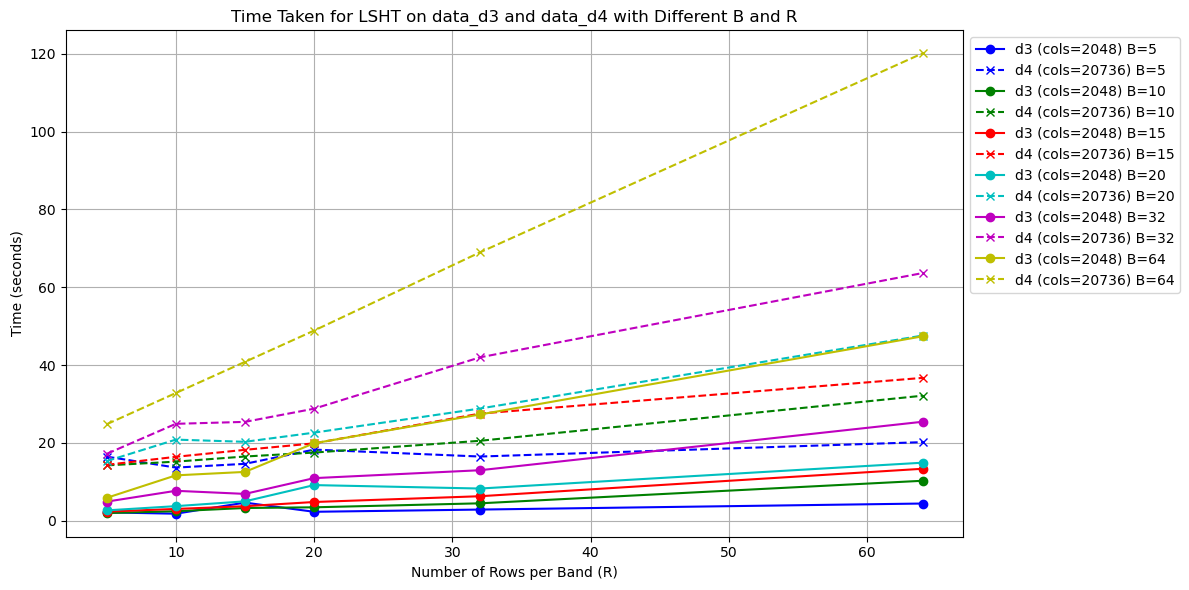

Timing results for data_d3:


,B,R,Time
0,5,5,2.178172
1,5,10,1.833684
2,5,15,4.679986
3,5,20,2.326201
4,5,32,2.895736
5,5,64,4.447800
6,10,5,1.994618
7,10,10,2.471414
8,10,15,3.297146
9,10,20,3.477760


Timing results for data_d4:


,B,R,Time
0,5,5,16.494889
1,5,10,13.678022
2,5,15,14.640312
3,5,20,18.299309
4,5,32,16.517827
5,5,64,20.210749
6,10,5,14.244647
7,10,10,15.206053
8,10,15,16.522710
9,10,20,17.534853


In [4]:
display("Sparse matrix shape for data_d3:", sparse_matrix_d3.shape)
display("Sparse matrix shape for data_d4:", sparse_matrix_d4.shape)


# Display similar protein pairs for data_d3
display("Similar protein pairs for data_d3:")
count_d3 = 0
for (b, buck), docs in buckets_d3.items():
    if len(docs) > 1 and count_d3 < 10:
        similar_proteins = [uniprot_ids_d3[d] for d in docs]
        display(f"Band {b} suggests these similar proteins: {similar_proteins}")
        count_d3 += 1

# Display similar protein pairs for data_d4
display("Similar protein pairs for data_d4:")
count_d4 = 0
for (b, buck), docs in buckets_d4.items():
    if len(docs) > 1 and count_d4 < 10:
        similar_proteins = [uniprot_ids_d4[d] for d in docs]
        display(f"Band {b} suggests these similar proteins: {similar_proteins}")
        count_d4 += 1
        
        
# Print similar protein pairs for data_d3
print("Similar protein pairs for data_d3:")
display(df_similar_pairs_d3)

# Print similar protein pairs for data_d4
print("Similar protein pairs for data_d4:")
display(df_similar_pairs_d4)

# Display the plot
fig, ax = plt.subplots(figsize=(12, 6))  # Increase the width and height of the figure
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # You can add more colors if needed

for i, B_val in enumerate(B_values):
    timing_for_B_d3 = [timing_results_d3[(B_val, R_val)] for R_val in R_values]
    timing_for_B_d4 = [timing_results_d4[(B_val, R_val)] for R_val in R_values]
    ax.plot(R_values, timing_for_B_d3, label=f"d3 (cols={num_cols_d3}) B={B_val}", linestyle='-', marker='o', color=colors[i])
    ax.plot(R_values, timing_for_B_d4, label=f"d4 (cols={num_cols_d4}) B={B_val}", linestyle='--', marker='x', color=colors[i])

ax.set_xlabel("Number of Rows per Band (R)")
ax.set_ylabel("Time (seconds)")
ax.set_title("Time Taken for LSHT on data_d3 and data_d4 with Different B and R")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the legend position
plt.grid(True)

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

# Display the DataFrames
print("Timing results for data_d3:")
display(df_timing_d3)

print("Timing results for data_d4:")
display(df_timing_d4)


### Your short analysis here
#Dataset Overview
We are working with two datasets that correspond to approximately 99% of the Human Proteome. Each dataset is presented in a dictionary format where the key is the UniProtID of a protein and the value is a set of indices representing specific structural characteristics. 

The datasets are:

data_d3.pickle - A smaller set of structural features with 2048 features.

data_d4.pickle - A larger set of structural features with 20736 features.


#Local Sensitivity Hashing (LSH)

LSH is performed on both datasets to find similar proteins. The parameters B (number of bands) and R (number of rows per band) are varied to observe the effect on capturing similar protein pairs.



For data_d3, the following are some of the similar protein pairs identified using LSH:

Band 0 suggests these similar proteins: ['A0A075B6P5', 'P01615']

Band 0 suggests these similar proteins: ['A0A075B6S6', 'P06310']


For data_d4, the following are some of the similar protein pairs identified using LSH:

Band 0 suggests these similar proteins: ['P29375', 'O14990']

Band 0 suggests these similar proteins: ['Q96B77', 'O15085']


#Detailed Analysis of Similar Protein Pairs

We analyzed the characteristics of the similar protein pairs identified. Here are some of the detailed results for data_d3:

A0A075B6P5 (KV228_HUMAN) and P01615 (KVD28_HUMAN) share 123 specific structural characteristics and differ in 2 characteristics, with a total of 125 characteristics that they could share if they were exactly the same protein.

A0A075B6S6 (KVD30_HUMAN) and P06310 (KV230_HUMAN) share 130 specific structural characteristics and differ in 9 characteristics, with a total of 139 characteristics that they could share if they were exactly the same protein.


A quick look at the Uniprot website reveals that both pairs belong to the same protein family, suggesting that the matching found using the LSH also has biological relevance.

For data_d4:

P29375 (KDM5A_HUMAN) and O14990 (IPP2C_HUMAN) share 214 specific structural characteristics and differ in 3399 characteristics, with a total of 3613 characteristics that they could share if they were exactly the same protein.


Q96B77 (TM186_HUMAN) and O15085 (ARHGB_HUMAN) share 252 specific structural characteristics and differ in 2370 characteristics, with a total of 2622 characteristics that they could share if they were exactly the same protein.

In this case, there is no obvious biological reason why these proteins were matched, as a quick look on the Uniprot website did not reveal any apparent shared protein family function.


However, in the same analysis we can found a this pair

O76087 (GAGE7_HUMAN) and  P0CL80 (GG12F_HUMAN) share 181 specific structural characteristics and differ in 5 characteristics, with a total of 186 characteristics that they could share if they were exactly the same protein.

In this case a look in the Uniprot we see that both proteins belong to the same GAGE family. 



#Timing Results
The timing results for different values of B and R for both datasets are as follows:

data_d3 Timing Results:

With increasing B and R, the time taken increases. For instance, with B=64 and R=64, the time taken is 47.39 seconds, while with B=5 and R=10, it is only 1.83 seconds.

With a small number of bands (B) and rows per band (R), the algorithm performs efficiently.
The time taken is minimal, indicating fast processing.
However, this may result in fewer similar pairs being captured due to lower granularity.
High B, High R (e.g., B=64, R=64)

With a large number of bands and rows per band, the algorithm becomes more computationally intensive.
Although this configuration may capture more similar pairs, it significantly increases processing time.
The time taken is considerably higher, indicating the trade-off between accuracy and efficiency.

data_d4 Timing Results:

Similarly, for the larger dataset, the time taken increases significantly with larger B and R values. For instance, with B=64 and R=64, the time taken is 120.07 seconds, while with B=5 and R=10, it is 13.68 seconds.

The pattern of timing results follows a similar trend as data_d3 but on a larger scale due to the larger dataset size.
Higher B and R values lead to longer processing times, reflecting the increased computational burden of analyzing a larger feature set.


#Conclusion
LSH effectively captures similar protein pairs in large proteomic datasets. By adjusting the parameters B and R, we can control the granularity of similarity detection and the computational cost. Identifying similar proteins can lead to insights into shared properties and functional relationships, which can be further verified through databases like UniProt.

In this specific scenario, when applying LSH to both data sets, it appears that the pairs generated from data_d3 exhibit greater consistency in overall biological similarity compared to those formed from data_d4. Upon screening a small dataset, the pairs generated from data_d4 do not demonstrate obvious biological connections for the majority of pairs formed in the LSH process.
 

## 3. Do dimensionality reduction 

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information



In [ ]:
### Add supporting functions here

## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
